In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import load_coco_json
from pycocotools.coco import COCO
from copy import deepcopy

img_root = "/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"

coco_anno_root = "/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/"
all_anno = os.path.join(coco_anno_root, "pre_all_complete_merge.json")

In [5]:
import torch

model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s] 
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cach

In [ ]:
def load_coco(json_file, img_root):
    ds_dicts = load_coco_json(json_file, img_root)

    coco = COCO(json_file)
    ids = {img_id: coco.imgs[img_id].get("patient_id") for img_id in coco.imgs}

    out = []
    for d in ds_dicts:
        d = deepcopy(d)
        img_id = d["image_id"]
        d["patient_id"] = ids[img_id]
        out.append(d)

    return out

DATASET_NAME = "all_ds"

# DatasetCatalog.remove("all_ds")
# MetadataCatalog.remove("all_ds")
if DATASET_NAME in DatasetCatalog.list():
    DatasetCatalog.remove(DATASET_NAME)

if DATASET_NAME in MetadataCatalog.list():
    MetadataCatalog.remove(DATASET_NAME)


DatasetCatalog.register(DATASET_NAME, lambda: load_coco(all_anno, img_root))

# register_coco_instances(DATASET_NAME, {}, all_anno, img_root)

all_dicts = DatasetCatalog.get("all_ds")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
all_dicts[0]

{'file_name': '/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2/raw1_01.D2(30m)-1.JPG',
 'height': 1200,
 'width': 600,
 'image_id': 0,
 'annotations': [{'bbox': [285, 23, 92, 92],
   'category_id': 0,
   'segmentation': [[293.4530547170928,
     31.409565453390474,
     374.82228905263577,
     31.409565453390474,
     374.82228905263577,
     105.12405691794979,
     288.7766520182292,
     106.92197188590337]],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'bbox': [277, 234, 94, 94],
   'category_id': 0,
   'segmentation': [[285.0355360243056,
     237.270762619463,
     365.469514480745,
     242.66450752332372,
     358.9225691978378,
     325.3685812348301,
     283.16499344026204,
     319.97482151661103]],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'bbox': [269, 471, 96, 96],
   'category_id': 0,
   'segmentation': [[276.61801733151833,
     479.98920922140474,
     357.98728249289775,
     474.5954791319023,
     354.24616649897416,
     559.09743818264

In [16]:
a = all_dicts[3]

img_path = a["file_name"]
anno = a["annotations"]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

anno

[{'bbox': [253, 106, 106, 106],
  'category_id': 0,
  'segmentation': [[261.8055597941081,
    118.48341232227489,
    348.9969126383464,
    109.70686058297542,
    351.3117345174154,
    200.98296974507554,
    261.8055597941081,
    209.759521484375]],
  'bbox_mode': <BoxMode.XYWH_ABS: 1>},
 {'bbox': [264, 326, 105, 105],
  'category_id': 0,
  'segmentation': [[274.922841389974,
    329.1205962122334,
    355.9413528442383,
    329.1205962122334,
    359.0277735392253,
    424.78498847563685,
    277.23765055338544,
    428.2955802447423]],
  'bbox_mode': <BoxMode.XYWH_ABS: 1>},
 {'bbox': [273, 564, 90, 90],
  'category_id': 0,
  'segmentation': [[278.00926208496094,
    578.3745788284953,
    357.4845631917318,
    567.8427456679502,
    359.7993850708008,
    644.1987096415877,
    277.23765055338544,
    651.2199510330273]],
  'bbox_mode': <BoxMode.XYWH_ABS: 1>},
 {'bbox': [258, 784, 104, 104],
  'category_id': 0,
  'segmentation': [[265.66357930501306,
    788.1341292394847,
   

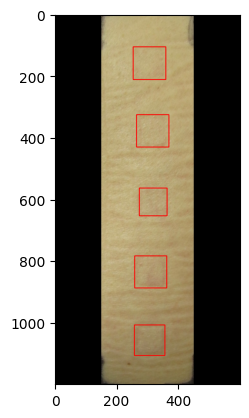

In [17]:
for k in anno:
    bbox = k["bbox"]
    x1, y1, w, h = [int(x) for x in bbox]
    x2, y2 = x1 + w, y1 + h
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img)
plt.show()

In [1]:
import torch, torch.nn as nn
from detectron2.modeling import META_ARCH_REGISTRY
from detectron2.structures import Instances, Boxes
from ultralytics import YOLO

WARNING ⚠️ torchvision==0.20 is incompatible with torch==2.6.
Run 'pip install torchvision==0.21' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from torchmetrics.functional import dice

ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
from detectron2.config import get_cfg, CfgNode as CN

cc = get_cfg()

cc.SOLVER

CfgNode({'LR_SCHEDULER_NAME': 'WarmupMultiStepLR', 'MAX_ITER': 40000, 'BASE_LR': 0.001, 'BASE_LR_END': 0.0, 'MOMENTUM': 0.9, 'NESTEROV': False, 'WEIGHT_DECAY': 0.0001, 'WEIGHT_DECAY_NORM': 0.0, 'GAMMA': 0.1, 'STEPS': (30000,), 'NUM_DECAYS': 3, 'WARMUP_FACTOR': 0.001, 'WARMUP_ITERS': 1000, 'WARMUP_METHOD': 'linear', 'RESCALE_INTERVAL': False, 'CHECKPOINT_PERIOD': 5000, 'IMS_PER_BATCH': 16, 'REFERENCE_WORLD_SIZE': 0, 'BIAS_LR_FACTOR': 1.0, 'WEIGHT_DECAY_BIAS': None, 'CLIP_GRADIENTS': CfgNode({'ENABLED': False, 'CLIP_TYPE': 'value', 'CLIP_VALUE': 1.0, 'NORM_TYPE': 2.0}), 'AMP': CfgNode({'ENABLED': False})})

In [2]:
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics.utils.loss import v8DetectionLoss

import torch


In [3]:
# e.g. cfg.MODEL.YOLO.MODEL_NAME = 
yolo = YOLO("yolo11n.pt")
yolo

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [3]:
from ultralytics.nn.modules.block import C3k2, C3k, Bottleneck
from ultralytics.nn.modules.block import SPPF, C2PSA, PSABlock
from ultralytics.nn.modules.conv import Conv
from ultralytics.nn.modules.head import Detect

In [24]:
c1 = 32

n = C3k2(c1, 64, n=1, c3k=False, e=0.5, shortcut=False, g=1)

t = torch.randn([1, c1, 128, 128])

print(n(t).shape)
print(n)

torch.Size([1, 64, 128, 128])
C3k2(
  (cv1): Conv(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (cv2): Conv(
    (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (m): ModuleList(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (cv2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
    )
  )
)


In [10]:
import torch.nn as nn

# yolo backbone
m1 = yolo.model.model[0]
m2 = yolo.model.model[1]
m3 = yolo.model.model[2]
m4 = yolo.model.model[3]
m5 = yolo.model.model[4]
m6 = yolo.model.model[5]
m7 = yolo.model.model[6]
m8 = yolo.model.model[7]
m9 = yolo.model.model[8]

# neck
sppf = yolo.model.model[9]
c2psa = yolo.model.model[10]
us1 = yolo.model.model[11]
cc1 = yolo.model.model[12]
c1 = yolo.model.model[13]
us2 = yolo.model.model[14]
cc2 = yolo.model.model[15]
c2 = yolo.model.model[16]

conv1 = yolo.model.model[17]
cc3 = yolo.model.model[18]
c3 = yolo.model.model[19]
conv2 = yolo.model.model[20]
cc4 = yolo.model.model[21]
c4 = yolo.model.model[22]

# det head
det_head = yolo.model.model[23]
dh1 = det_head.cv2
dh2 = det_head.cv3
dfl = det_head.dfl





# m2 = yolo.model.model[7]
# m2 = yolo.model.model[7]

backbone = nn.Sequential(*[eval(f"m{i}") for i in range(1, 10)])

backbone



Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
       

In [5]:
t = torch.randn([1, 3, 300, 120])

print(backbone(t).shape)

torch.Size([1, 256, 10, 4])


In [ ]:
class MyYolo(nn.Module):
    def __init__(self):
        super.__init__()

        import ultralytics
        from ultralytics import YOLO

        yolo = YOLO("yolo11n.pt")

        self.backbone = self._make_bakcbone(yolo)
        self.neck = self._make_neck(yolo)

    def _make_bakcbone(self, yolo):
        backbone = nn.Sequential(
            yolo.model.model[0],
            yolo.model.model[1],
            yolo.model.model[2],
            yolo.model.model[3],
            yolo.model.model[4],
            yolo.model.model[5],
            yolo.model.model[6],
            yolo.model.model[7],
            yolo.model.model[8],
        )

        return backbone

    def _make_neck(self, yolo):

class Yolo_Backbone(nn.Module):
    def __init__(self):
        super.__init__()

        import ultralytics
        from ultralytics import YOLO

        yolo = YOLO("yolo11n.pt")

        self.conv1 = yolo.model.model[0]
        self.conv2 = yolo.model.model[1]
        self.c3k2_1 = yolo.model.model[2]
        self.conv3 = yolo.model.model[3]
        self.c3k2_2 = yolo.model.model[4]
        self.conv4 = yolo.model.model[5]
        self.c3k2_3 = yolo.model.model[6]
        self.conv5 = yolo.model.model[7]
        self.c3k2_4 = yolo.model.model[8]

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.c3k2_1(x)

        x = self.conv3(x)
        x_8 = self.c3k2_2(x)
        
        x = self.conv4(x)
        x_16 = self.c3k2_3(x)
        
        x = self.conv5(x)
        x_32 = self.c3k2_4(x)

        return x_8, x_16, x_32


class Yolo_Neck(nn.Module):

    def __init__(self):
        super.__init__()

        import ultralytics
        from ultralytics import YOLO

        yolo = YOLO("yolo11n.pt")

        self.sppf = yolo.model.model[9]
        self.c2psa = yolo.model.model[10]

        self.us1 = yolo.model.model[11]
        self.concat_1 = yolo.model.model[12]
        self.c3k2_1 = yolo.model.model[13]
        self.us2 = yolo.model.model[14]
        self.concat_2 = yolo.model.model[15]
        self.c3k2_2 = yolo.model.model[16]

        self.conv1 = yolo.model.model[17]
        self.concat_3 = yolo.model.model[18]
        self.c3k2_3 = yolo.model.model[19]
        self.conv2 = yolo.model.model[20]
        self.concat_4 = yolo.model.model[21]
        self.c3k2_4 = yolo.model.model[22]

    def forward(self, x_8, x_16, x_32):

        x_32 = self.sppf(x_32)
        x_32 = self.c2psa(x_32)
        
        x = self.us1(x_32)
        x = self.concat_1([x, x_16])
        x_16 = self.c3k2_1(x)

        x = self.us2(x_16)
        x = self.concat_2([x, x_8])
        x_8 = self.c3k2_2(x)

        x = self.conv1(x_8)
        x = self.concat_3(x_8, x_16)
        x_16 = self.c3k2_3(x)

        x = self.conv2(x_16)
        x = self.concat_4(x, x_32)
        x_32 = self.c3k2_4(x)

        return x_8, x_16, x_32



class Yolo_DetHead(nn.Module)
    def __init__(self):
        super.__init__()

        import ultralytics
        from ultralytics import YOLO

        yolo = YOLO("yolo11n.pt")

        det_head = yolo.model.model[23]
        self.dh1 = det_head.cv2
        self.dh2 = det_head.cv3
        self.dfl = det_head.dfl

    def forward(self, x_8, x_16, x_32):



        




ModuleList(
  (0): Sequential(
    (0): Sequential(
      (0): DWConv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): DWConv(
        (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80, bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, tra

In [1]:
640/80

8.0

In [2]:
640/40

16.0

In [3]:
640/20

32.0

In [ ]:
class Concat(nn.Module):
    """
    Concatenate a list of tensors along specified dimension.

    Attributes:
        d (int): Dimension along which to concatenate tensors.
    """

    def __init__(self, dimension=1):
        """
        Initialize Concat module.

        Args:
            dimension (int): Dimension along which to concatenate tensors.
        """
        super().__init__()
        self.d = dimension

    def forward(self, x: list[torch.Tensor]):
        """
        Concatenate input tensors along specified dimension.

        Args:
            x (list[torch.Tensor]): List of input tensors.

        Returns:
            (torch.Tensor): Concatenated tensor.
        """
        return torch.cat(x, self.d)

In [4]:
22000/8

2750.0

In [6]:
42680/16

2667.5